### Data exploratory analysis

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [143]:
url = r'https://raw.githubusercontent.com/MSI17819/Berlin_bike_theft_prediction/main/Berlin_bike_thief_file_for_analysis.csv'

df = pd.read_csv(url, sep=',', encoding="utf-8")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31816 entries, 0 to 31815
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Record_date              31816 non-null  object
 1   Record_day               31816 non-null  int64 
 2   Record_month             31816 non-null  int64 
 3   Record_year              31816 non-null  int64 
 4   Stealing_date            31816 non-null  object
 5   Stealing_hour            31816 non-null  int64 
 6   Report_stealing_date     31816 non-null  object
 7   Report_stealing_hour     31816 non-null  int64 
 8   Berlin_code_area         31816 non-null  int64 
 9   Bike_value               31816 non-null  int64 
 10  Unsuccesful_attempt      31816 non-null  object
 11  Bike_type                31816 non-null  object
 12  Crime_type               31816 non-null  object
 13  Crime_reason             31816 non-null  object
 14  Administrative_district  31816 non-nul

#### Creat DataFrame copy for next visualisation analysis

In [144]:
df_copy = df.copy()

#### Display DataFrame copy

#### Change Record_day column for verbal day representation 

In [145]:
df_copy['Record_day'] = pd.to_datetime(df_copy['Record_date']).dt.day_name()

In [146]:
df_copy.groupby('Record_day')[['Record_date']].count().sort_values(by='Record_date', ascending=False)

,Record_date
Record_day,
Monday,5436
Tuesday,5092
Wednesday,5061
Thursday,4789
Friday,4373
Sunday,3706
Saturday,3359


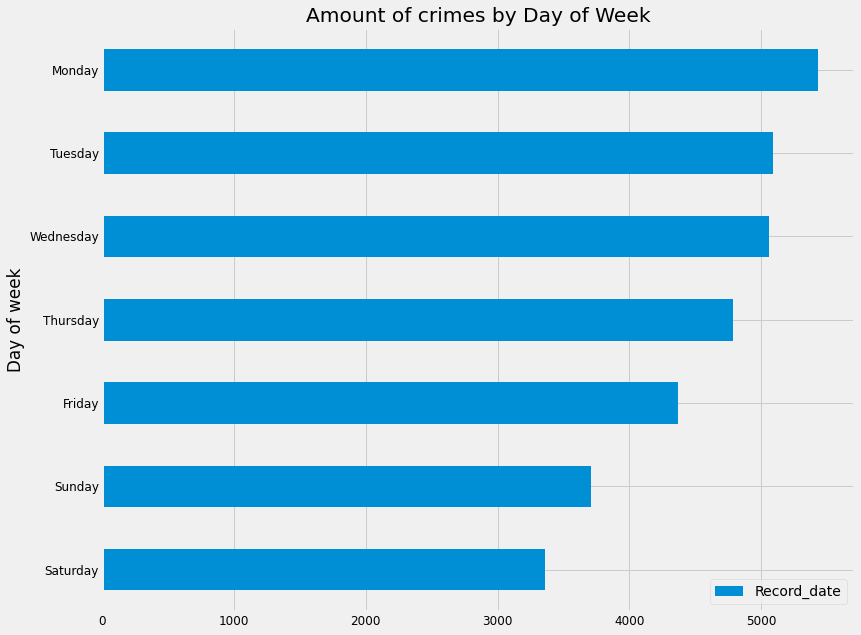

In [147]:
df_copy.groupby('Record_day')[['Record_date']].count()\
                .sort_values(by='Record_date', ascending=True)\
                .plot(kind='barh',
                figsize=(12,10),
                fontsize=12,
                title='Amount of crimes by Day of Week',
                xlabel='Day of week',
                grid=True);

In [148]:
df_copy.groupby('Administrative_district')[['Record_date']].count().sort_values(by=['Record_date'], ascending=False)

,Record_date
Administrative_district,
Pankow,5015
Mitte,4482
Friedrichshain-Kreuzberg,4377
Charlottenburg-Wilmersdorf,3479
Tempelhof-Schöneberg,2659
Treptow-Köpenick,2494
Neukölln,2479
Steglitz-Zehlendorf,2019
Lichtenberg,1783


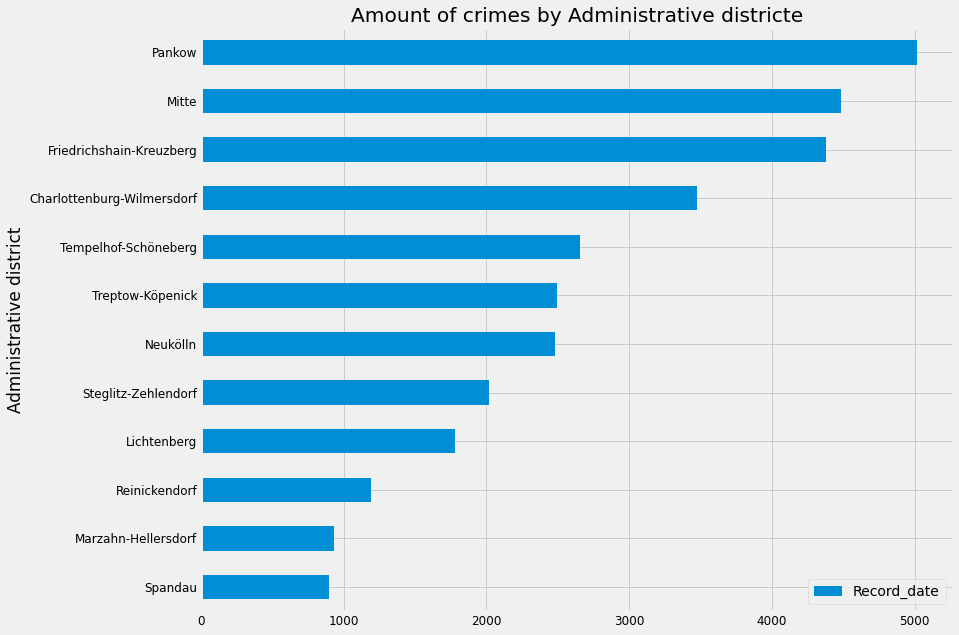

In [149]:
df_copy.groupby('Administrative_district')[['Record_date']].count()\
                                    .sort_values(by=['Record_date'], ascending=True)\
                                    .plot(kind='barh',
                                    figsize=(12,10),
                                    fontsize=12,
                                    title='Amount of crimes by Administrative districte',
                                    xlabel='Administrative district',
                                    grid=True);

In [150]:
df_copy.groupby('Bike_type')[['Record_date']].count().sort_values(by='Record_date', ascending=False)

,Record_date
Bike_type,
Men,14649
Women,9298
Bike,4724
Mountain,1399
Child,1262
Racing,437
Cargo,47


In [151]:
df_copy.groupby('Crime_type')[['Record_date']].count().sort_values(by='Record_date', ascending=False)

,Record_date
Crime_type,
Theft,30437
Break-in,1379


#### Drop column *Record_date*

In [152]:
df.drop(["Record_date"], axis=1, inplace=True)

In [153]:
df['Stealing_date'] = pd.to_numeric(pd.to_datetime(df['Stealing_date']))
df['Report_stealing_date'] = pd.to_numeric(pd.to_datetime(df['Report_stealing_date']))

### Machine Learning prediction modeling

In [154]:
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, StandardScaler, OneHotEncoder

In [155]:
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import statistics
from sklearn.metrics import accuracy_score

#### Split data to 70% train and 30% test (the size of dataset is big almost 31 thousand)

In [156]:
X = df.drop(['Unsuccesful_attempt'], axis=1)
y = df['Unsuccesful_attempt']

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 0, stratify = y)

#### Transform data to acceptable form for Machine Learning algoritm

In [134]:
transformer = ColumnTransformer(transformers=[
    ('tnf1', OneHotEncoder(handle_unknown='ignore'), ['Bike_type', 'Crime_type', 'Crime_reason',
                               'Administrative_district', 'District','Quarter', 'Street_name']),
    ('trf2', StandardScaler(), ['Record_day', 'Record_month', 'Stealing_date','Report_stealing_date',
                                'Record_year', 'Stealing_hour', 'Report_stealing_hour'])],
                                remainder='passthrough')

X_train = transformer.fit_transform(X_train)

X_test = transformer.transform(X_test)

#### Transform y-variable by LabelEncoder for two classes (0 and 1):
- Crime happend *(Unsucessfuly attempt == No)* = label with number 0
- Crime unhappend *(Unsucessfuly attempt == Yes)* = label with number 1 

In [158]:
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)

y_test = le.transform(y_test)

##### Dataset is highly unbalanced:
- 31 706 record are crime *(Unsuccesful_attempt" == No, so crime happend)*
- 110 record are not crime *(Unsuccesful_attempt" == Yes, so crime unhappend)*

In [136]:
df["Unsuccesful_attempt"].value_counts()

No     31706
Yes      110
Name: Unsuccesful_attempt, dtype: int64

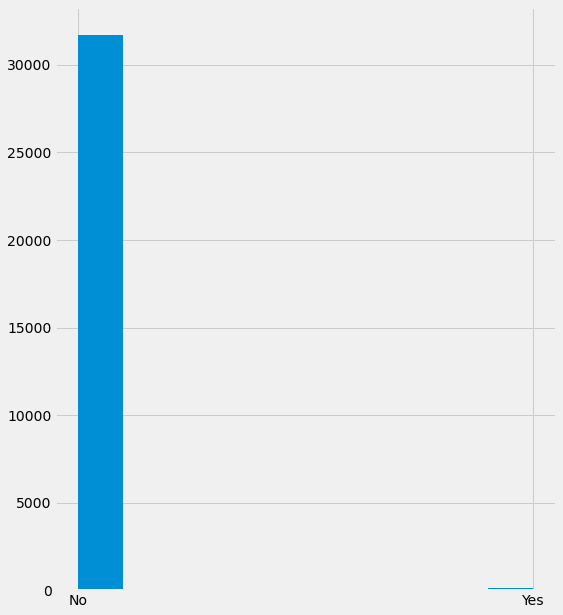

In [137]:
plt.style.use("fivethirtyeight")
fig = plt.figure(figsize=(8, 10))
plt.hist(df["Unsuccesful_attempt"])
plt.show()

##### Creat simply baseline model with the use a mode statistics, for simply class prediction. This model act as our basline for other ML prediction models

In [160]:
baseline_model = statistics.mode(y_train)

y_pred_baseline_model = [baseline_model] * len(y_test)

score_baseline_model = accuracy_score(y_test, y_pred_baseline_model)

print(f'Accuracy score {round(score_baseline_model * 100, 2)}%')

Accuracy score 99.65%
